## Loading data from the simulation output - the automatic way

This example uses a third party library, disgrid, to load data from the simulation outputs with minimal effort.
Disclaimer, I (Thomas Rometsch) wrote the tool. Feel free to just use `np.genfromtxt` to load the time series data.

We will use the data from the simulation in the quickstart example, so make sure you ran this beforehand.

We'll first create a Data object and ask what's available in the output. 

In [1]:
#!pip install git+https://github.com/rometsch/disgrid
from disgrid import Data
d = Data("quickstart/output/out")
d.avail()

{'fluids': {'gas': {'2d': ['dens', 'energy', 'vrad', 'vtheta'],
   'scalar': ['time step',
    'analysis time step',
    'physical time',
    'mass',
    'radius',
    'angular momentum',
    'total energy',
    'internal energy',
    'kinematic energy',
    'potential energy',
    'radial kinetic energy',
    'azimuthal kinetic energy',
    'eccentricity',
    'periastron',
    'viscous dissipation',
    'luminosity',
    'pdivv',
    'inner boundary mass inflow',
    'inner boundary mass outflow',
    'outer boundary mass inflow',
    'outer boundary mass outflow',
    'wave damping inner mass creation',
    'wave damping inner mass removal',
    'wave damping outer mass creation',
    'wave damping outer mass removal',
    'density floor mass creation',
    'aspect ratio',
    'indirect term nbody x',
    'indirect term nbody y',
    'indirect term disk x',
    'indirect term disk y',
    'snapshot number',
    'monitor number',
    'hydrostep number',
    'Number of Hydrosteps in l

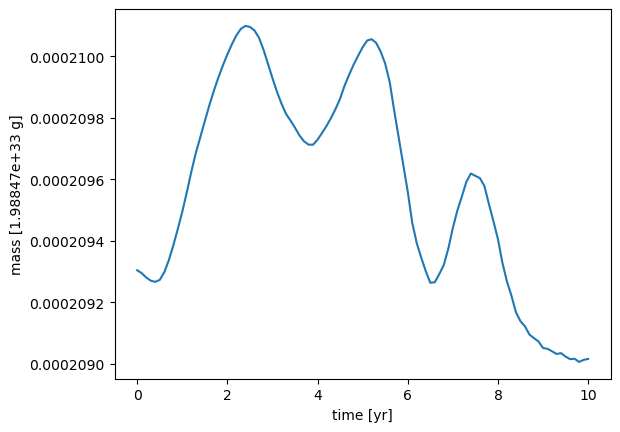

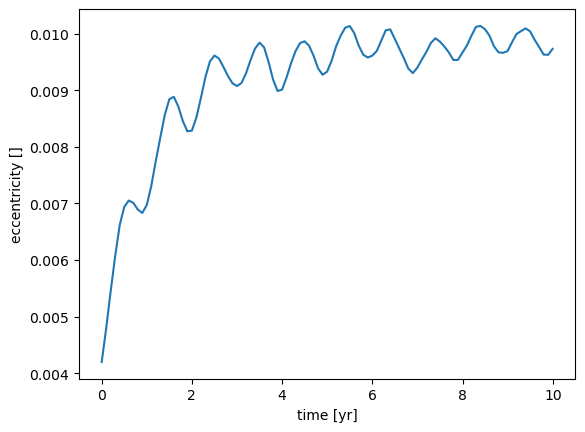

In [2]:
import matplotlib.pyplot as plt

for varname in ["mass", "eccentricity"]:
    fig, ax = plt.subplots()
    x = d.get(dim="scalar", var=varname)
    ax.plot(x.time.to("yr"), x.data)
    ax.set_ylabel(f"{varname} [{x.data.unit}]")
    ax.set_xlabel(f"time [yr]")

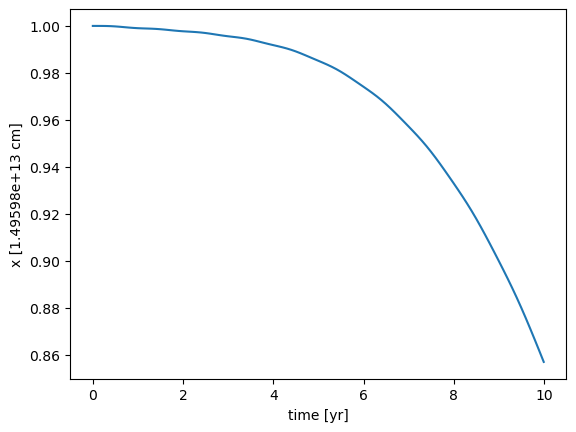

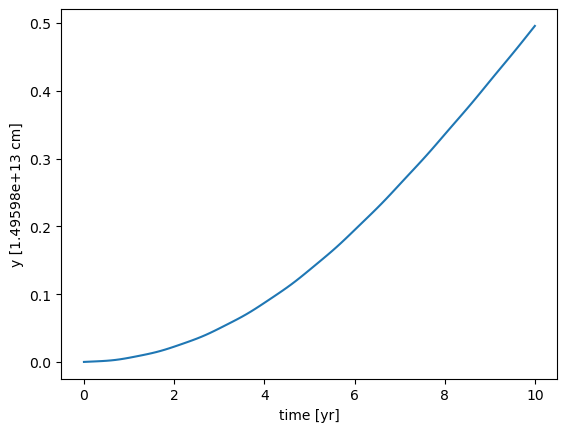

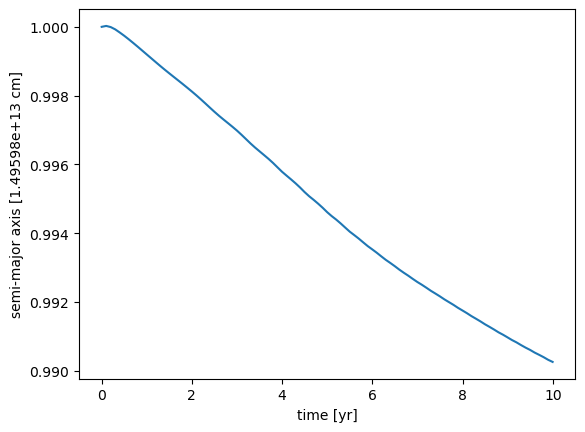

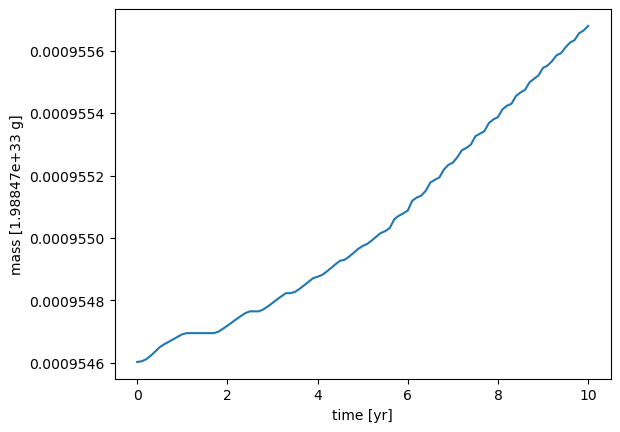

In [3]:
n_planet = 1
for varname in ["x", "y", "semi-major axis", "mass"]:
    fig, ax = plt.subplots()
    x = d.get(dim="scalar", var=varname, planet=n_planet)
    ax.plot(x.time.to("yr"), x.data)
    ax.set_ylabel(f"{varname} [{x.data.unit}]")
    ax.set_xlabel(f"time [yr]")

In [4]:
import numpy as np
import matplotlib.colors as mplcolors

def plot_field(data, name, N, ax=None, dataunit=None, vmin=None, vmax=None, cmap="viridis"):
    field = data.get(var=name, dim="2d", N=N)
    if dataunit is None:
        dataunit = field.data.unit
    Z = field.data.to_value(dataunit)

    ri = field.grid.get_interfaces("r").to_value("au")
    phii = field.grid.get_interfaces("phi").to_value("rad")
    PHI, R = np.meshgrid(phii, ri)
    X = R*np.cos(PHI)
    Y = R*np.sin(PHI)

    if ax is None:
        fig, ax = plt.subplots(dpi=150)
    else:
        fig = ax.get_figure()

    norm = mplcolors.Normalize(vmin=vmin, vmax=vmax)
    pcm = ax.pcolormesh(X,Y,Z, norm=norm, cmap=cmap)
    ax.set_aspect("equal")

    t = field.time.to_value("kyr")
    ax.set_title(f" t={t:.2e}kyr, N={N}")

    cbar = fig.colorbar(pcm, ax=ax)
    cbar.set_label(f"{name} [{dataunit}]")
    
    return fig

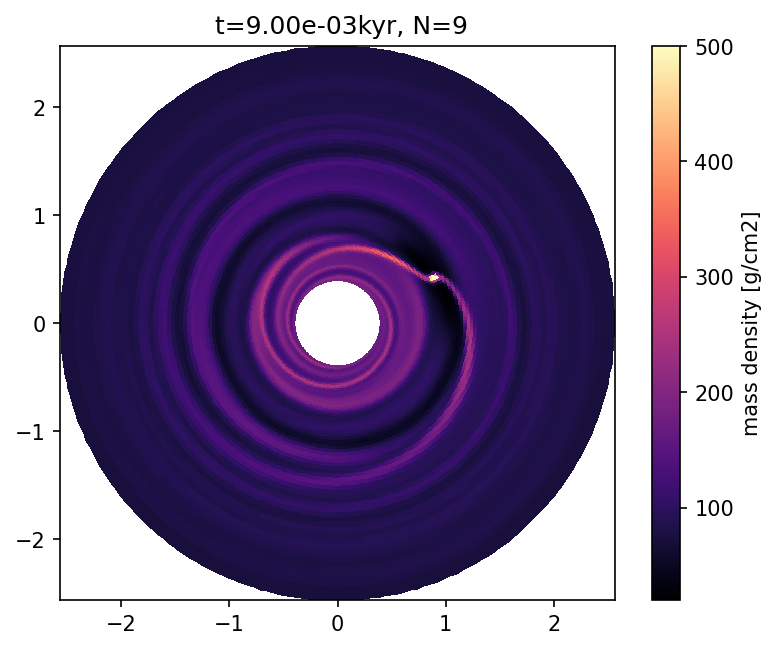

In [8]:
Nlast = d.avail()["Nlast"]-1
plot_field(d, "mass density", Nlast, dataunit="g/cm2", cmap="magma", vmax=500);

Text(0, 0.5, '$\\Sigma$ [g/cm2]')

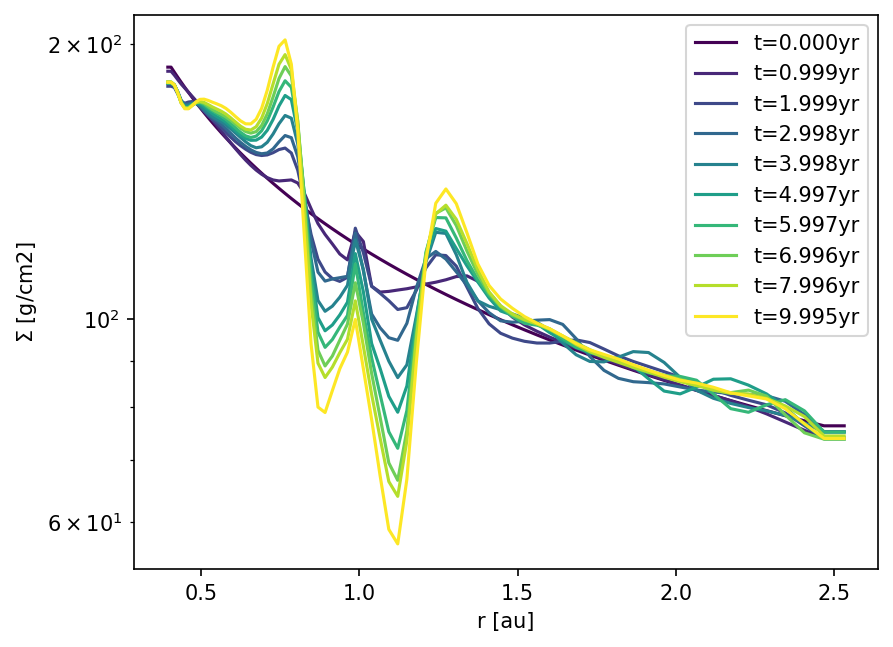

In [6]:
name = "mass density"
dataunit = "g/cm2"

Nfirst = d.avail()["Nfirst"]
Nlast = d.avail()["Nlast"]

fig, ax = plt.subplots(dpi=150)

field = d.get(dim="2d", var="mass density", N=0)
profile0 = np.average(field.data.to_value(dataunit), axis=1)

cmap = plt.cm.get_cmap("viridis")

inds = np.linspace(Nfirst, Nlast, 10, dtype=int)
for k, n in enumerate(inds):
    color = cmap(k/(len(inds)-1))
    
    field = d.get(dim="2d", var="mass density", N=n)
    r = field.grid.get_centers("r").to_value("au")
    Z = field.data.to_value(dataunit)
    
    y = np.average(Z, axis=1)
    
    t = field.time.to_value("yr")
    # ax.plot(r, (profile-profile0)/profile0, label=f"t={t:.3f}yr")
    line, = ax.plot(r, y, label=f"t={t:.3f}yr", color=color)
    
ax.legend()
ax.set_yscale("log")
ax.set_xlabel("r [au]")
ax.set_ylabel(fr"$\Sigma$ [{dataunit}]")